# TP Challenge

Adrien PASQUESOONE

Nathan LESOURD

Importations des bibliothèques

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Importations des données : learn set (avec labels) et test set (sans labels)

In [ ]:
# training set
ff_train = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/Challenge IML/train.csv", delimiter=",", dtype="str")
# test set
ff_test = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/Challenge IML/test_inputs.csv", delimiter=",", dtype="str")
Y_train = ff_train[1:,0]
Xtrain = ff_train[1:,1:]
Xtest = ff_test[1:,:]

Normalisation des données pour améliorer les résultats de notre modèle

In [ ]:
#normalisation
sc = StandardScaler(with_mean=True, with_std=True)
sc = sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

Réalisation d'une ACP pour réduire le nombre de dimensions de l'image (initialement 784) pour pouvoir accélerer l'apprentissage du modèle tout en conservant une grande variance expliquée.

Cela permet aussi de conserver les informations principales tout en rejetant le bruit qui pourrait exister dans les images.

<ipython-input-4-5ec6ba1e2339>:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = plt.stem(range(1, valprop.size + 1), cum_var_exp, "-r", label="Individual")


Variance expliquée:  0.9776166393969365


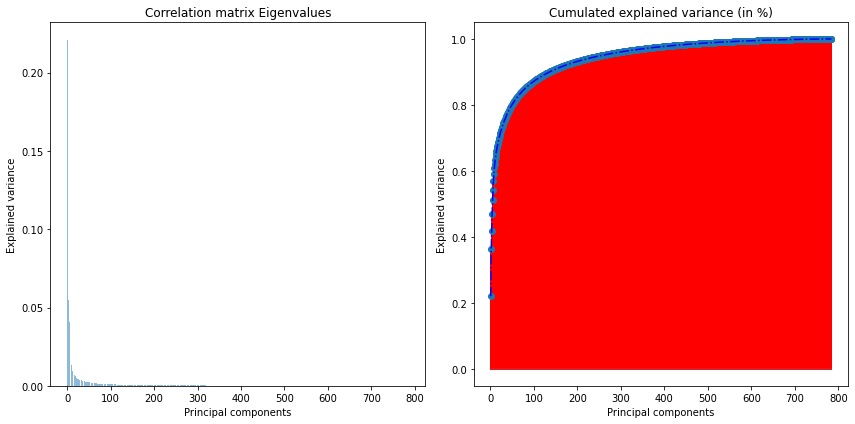

In [ ]:
pca = PCA()
pca.fit(Xtrain)
nb_composante = 400
def plot_spectre_variance_expl(valprop):
    tot = sum(np.abs(valprop))
    var_exp = [(i / tot) for i in sorted(np.abs(valprop), reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, valprop.size + 1), np.abs(valprop), alpha=0.5, align="center", label="Individual")
    plt.title("Correlation matrix Eigenvalues")
    plt.ylabel("Explained variance")
    plt.xlabel("Principal components")
    plt.subplot(1, 2, 2)
    markerline, stemlines, baseline = plt.stem(range(1, valprop.size + 1), cum_var_exp, "-r", label="Individual")
    plt.setp(stemlines, "color", "r", "linewidth", 2)
    plt.plot(range(1, valprop.size + 1), cum_var_exp, "b-.",label="Cumulative")
    print("Variance expliquée: ",cum_var_exp[nb_composante])
    plt.title("Cumulated explained variance (in %)")
    plt.ylabel("Explained variance")
    plt.xlabel("Principal components")
    plt.tight_layout()
    plt.show()

# Plot the spectrum
plot_spectre_variance_expl(pca.explained_variance_ratio_)

On constate qu'en conservant uniquement les 400 premières composantes principales on a 98% de la variance expliquée.

On va maintenant visualiser la classification en deux 2D avec les deux premières composantes de l'ACP.

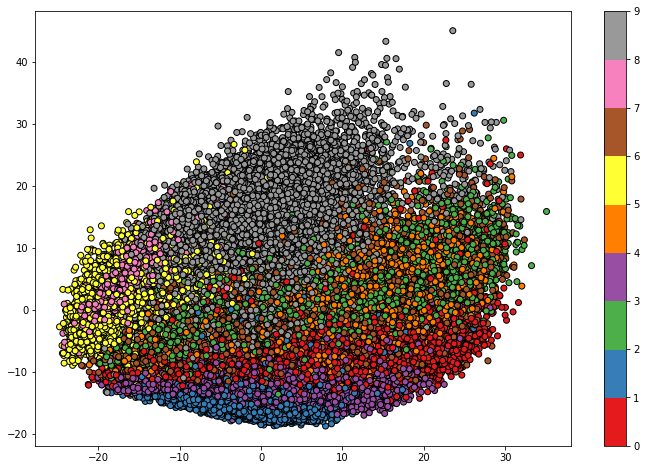

<function print>

In [ ]:
# Projection
n_axes = 2
pca.n_components = n_axes
Xtrain_proj_ais = pca.transform(Xtrain)
Xtest_proj_ais = pca.transform(Xtest)
# 2d visualization
plt.figure(figsize=(12,8))
Y_train = Y_train.astype('int')
plt.scatter(Xtrain_proj_ais[:,0], Xtrain_proj_ais[:, 1], c=Y_train, cmap=plt.cm.Set1,edgecolor="k")
plt.colorbar()
plt.show()
print

Dans ce cas, on constate que la classification à l'aide d'un modèle linéaire n'est pas la plus adapatée car la classification avec des hyperplans n'est pas la plus pertinente. Par la suite on fera un SVM avec comme kernel "rbf" pour passer à un modèle non linéaire.

Projection selon les deux premières composantes:

In [ ]:
Xtrain_proj = Xtrain_proj_ais[:,:nb_composante] #décrit 97% de l'info
Xtest_proj = Xtest_proj_ais[:,:nb_composante] #décrit 97% de l'info

A l'aide de la fonction grid search nous allons déterminer les hyperparamètres de notre modèle. En ce qui concerne gamma, nous allons le fixer à l'aide de la fonction SVC avec la paramètre gamma='scale'. Il fixe gamma=1 / (n_features * X.var()) ce qui est une bonne approximation du gamma optimal. 

Par conséquent, il nous reste à determiner C. Comme l'apprentissage du modèle avec l'utilisation du grid search est très long, nous allons determiner C avec un petit learn set (5%) puis tester avec cette valeur pour un grand lean set. 

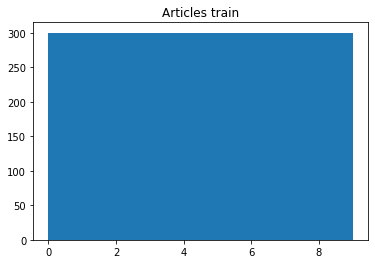

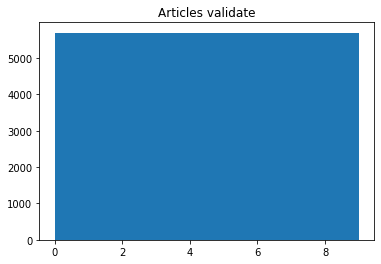

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3, estimator=SVC(cache_size=12000, max_iter=2000, tol=0.01),
             n_jobs=-1,
             param_grid={'C': array([  0.31622777,   0.40194503,   0.51089698,   0.64938163,
         0.82540419,   1.04913973,   1.33352143,   1.69498815,
         2.15443469,   2.73841963,   3.48070059,   4.42418555,
         5.62341325,   7.14770577,   9.08517576,  11.54781985,
        14.67799268,  18.65663579,  23.71373706,  30.1416253 ,
        38.3118685 ,  48.69675252,  61.89658189,  78.67438077,
       100.        ])},
             scoring='accuracy', verbose=1)

In [ ]:
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain_proj, Y_train, shuffle=
True, test_size=0.95, stratify=Y_train)
plt.title('Articles train')
plt.hist(Ytrain)
plt.show()
plt.title('Articles validate')
plt.hist(Yval)
plt.show()

C_grid = np.logspace(-0.5,2,25)

# the grid
parameters = {"C": C_grid}
# the classifier
clf_rbf = SVC(kernel="rbf", gamma="scale", tol=0.01, cache_size=12000, max_iter = 2000)
# Perf a K-fold validation using the accuracy as the performance measure
K = 3
# we will dot it on a grid search using n_jobs processors
clf_rbf = GridSearchCV(clf_rbf, param_grid=parameters, cv=K, scoring="accuracy", verbose=1, n_jobs = -1)

clf_rbf.fit(Xtrain, Ytrain)


In [ ]:
# Get the best parameters
print("\n Rbf kernel - optimal hyper-parameters = {}".format(clf_rbf.best_params_))
print("\n Rbf kernel - best cross-val accuracy = {}".format(clf_rbf.best_score_))


 Rbf kernel - optimal hyper-parameters = {'C': 4.424185553847919}

 Rbf kernel - best cross-val accuracy = 0.8273333333333333


Après plusieurs essais, nous avons vu que le meilleur C était de l'ordre de 10.

In [ ]:
Yval_pred = clf_rbf.predict(Xval)
print("Acccuracy test : ",accuracy_score(Yval_pred,Yval))

Acccuracy test :  0.847859649122807


Apprentissage sur un plus grand learn set (90%) pour améliorer la précision du modèle avec C=10.

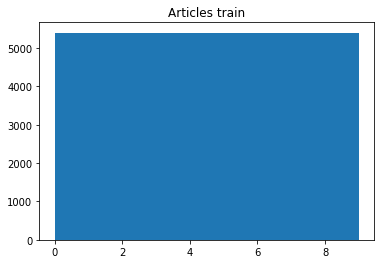

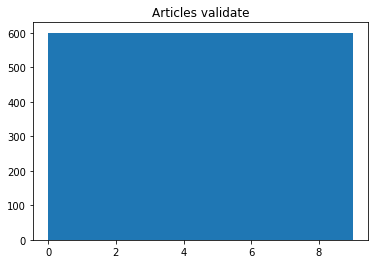

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Acccuracy test :  0.8985


In [ ]:
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain_proj, Y_train, shuffle=
True, test_size=0.1, stratify=Y_train)
plt.title('Articles train')
plt.hist(Ytrain)
plt.show()
plt.title('Articles validate')
plt.hist(Yval)
plt.show()
clf_rbf = SVC(kernel="rbf", C=10, gamma="scale", tol=0.01, cache_size=12000, max_iter = 2000)
clf_rbf.fit(Xtrain, Ytrain)
Yval_pred = clf_rbf.predict(Xval)
print("Acccuracy test : ",accuracy_score(Yval_pred,Yval))

On applique maintenant notre modèle au test set sans labels pour pouvoir envoyer nos données prédites à Kaggle 

In [ ]:
Ytest_pred = clf_rbf.predict(Xtest_proj)

On met les résultats en forme sous format csv

In [ ]:
id = np.arange(10000).reshape(10000, 1)
Ytest_pred_formated = Ytest_pred.reshape(10000,1)
formated_result = np.concatenate((id, Ytest_pred_formated), 1)
title = np.array(["id", "predicted"]).reshape(1,2)
formated_result = np.concatenate((title, formated_result))
df = pd.DataFrame(formated_result)
df.to_csv('submission.csv', header=False, index=False)